In [275]:
import numpy as np
import scipy as sp
from scipy import stats
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
import pickle
from functools import reduce

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

Mostly the same as NotebookMonteCarlo

In [3]:
# Constants and other setup variables. Spherical points should be (theta, phi)
lisa_resolution = 1*np.pi/180
NSIDE = 128
Npix = hp.nside2npix(NSIDE)

In [4]:
# Sample MC values
time_vals = [500000]
emri_array = [5000]
mbh_array = [50]position_array = [1]

In [97]:
# Rate constants. Event rates are events/year.

# time_diff = 100000
low_energy_rate = 50
high_energy_rate = 70
time_diff = 500 #usually 500
mbh_rate = 3
emri_rate = 500 #usually 500
position_factor = 1
sec_in_year = 60*60*24*365
month = sec_in_year/12
day = sec_in_year/365

In [6]:
def Ang2Vec(theta,phi):
        """ Takes spherical angles (theta [inclination], phi [azimuth]) and returns a point on the surface a sphere """
    return np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])

In [7]:
def add_time(count):
        """ Uniform distribution of events throughout a year """
    time = np.random.randint(sec_in_year, size=count)
    return time

In [8]:
def random_point(count):
        """ Get random points on a sphere (uniform distribution)"""
    phi = np.random.random(count)*2*np.pi
    costheta = np.random.random(count)*2 - 1
    theta = np.arccos(costheta)
    return np.array([theta, phi]).T

In [9]:
def lisa_noise(count):
    """ Noise on LISA observations """ 
    return np.ones(count)*lisa_resolution

In [10]:
def lisa_events(poisson_lambda):
    """ Naive generation of LISA events """ 
    k = np.random.poisson(lam=poisson_lambda)
    points = random_point(k)
    noise = lisa_noise(k).T
    time = add_time(k)
    energy = np.zeros(k)
    events = [points, noise, time, energy]
    return events

In [229]:
def load_simulation_data(filename):
    """ Load simulated HEN events """
    gen2bundle = pickle.load(open(filename, 'rb'), encoding='bytes')
    events_bundle = []
    for gen2data in gen2bundle:
        gen2energy = gen2data[0]
        gen2noises = gen2data[1]
        gen2thet = gen2data[2]
        gen2phi = gen2data[3]
        gen2time = gen2data[4]
        gen2events = [np.array([gen2thet, gen2phi]).T, gen2noises, gen2time, gen2energy]
        events_bundle.append(gen2events)
    
    return events_bundle

In [231]:
# Sample signal of HEN events
samp_signal = load_simulation_data('data/sample_signal_bundle.p')

In [12]:
def add_events(e1, e2):
    """ Format list of events. Allows to "add" event lists and preserve
    the format """
    enew0 = np.row_stack((e1[0], e2[0]))
    enew1 = np.concatenate((e1[1], e2[1]))
    enew2 = np.concatenate((e1[2], e2[2]))
    enew3 = np.concatenate((e1[3], e2[3]))
    
    return enew0, enew1, enew2, enew3

In [531]:
def position_coincident(p1, p2, n1, n2):
        """ Check if two positions and associated noises are coincident """
    pvec1 = Ang2Vec(*p1)
    pvec2 = Ang2Vec(*p2)
    dist = np.linalg.norm(pvec1[:,None] - pvec2, axis=0)
    booldist = dist < (n1 + n2)
    return booldist

In [14]:
def time_coincident(t1, t2, source_count=3):
    """ Check if there are time coincident events with only those with at least 3 (source_count) in the window counting as a full event. """
    keys = []
    vals = []
#     diffs = np.subtract.outer(t1,t2)
    diffs = t1[:,None] - t2[None,:]
    booldiffs = (diffs < time_diff)*(-1*time_diff < diffs)
    possij = np.arange(diffs.shape[1])
    
    for i,v in enumerate(booldiffs):
        if np.sum(v) > source_count:
            keys.append(i)
            vals.append(possij[v])
    return np.array(keys), vals

In [566]:
def overlap(hen, gw, source_count=2):
    """ Given events, noises, and times, calculate the number of overlaps """
    p1, n1, t1, _ = gw
    p2, n2, t2, e2 = hen
    ks, vs = time_coincident(t1, t2, source_count=source_count)
    overlap_counter = 0
    theta_overlap = []
    energy_overlap = []
    for i,v in enumerate(ks):
        pos_1 = p1[v]
        noise_1 = n1[v]
        pos_2 = p2[vs[i]]
        noise_2 = n2[vs[i]]
        l = position_coincident(pos_1, pos_2.T, noise_1, noise_2)
        if np.sum(l) > source_count:
            theta_overlap.append(np.cos(pos_2[l][:,0]))
            energy_overlap.append(e2[vs[i]][l])
            overlap_counter += 1
    
    return overlap_counter, theta_overlap, energy_overlap

In [16]:
def monte_carlo_run(neutrino_data):
    """ Single Monte Carlo run that generates all events and calculates coincident pairs """ 
    high = neutrino_data
    emri = lisa_events(emri_rate)
    mbh = lisa_events(mbh_rate)
    h_e, he_p, he_n = overlap(high, emri)
    h_m, hm_p, hm_n = overlap(high, mbh)
    
    return np.array([h_e, h_m]), np.array([he_p,hm_p]), np.array([he_n, hm_n])

(array([ 97.,  95.,  99., 105.,  91.,  87., 114., 103.,  94., 115.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

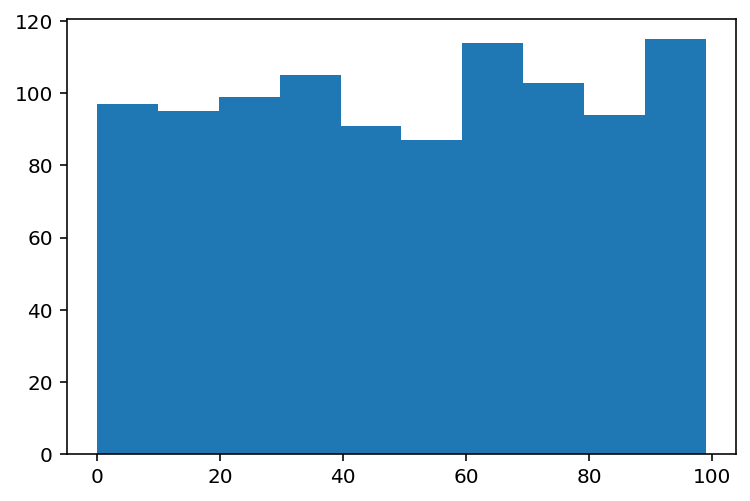

In [245]:
# np.random.randint(0, len(signal_bundle))

In [246]:
def mc(neutrino_bundle, n=100):
     """ Monte carlo function. 100 (n) runs of monte_carlo_run """
    lval = []
    tval = []
    enerval = []
    neutrino_length = len(neutrino_bundle)
    for i in tqdm(range(n)):
        neutrinos = neutrino_bundle[np.random.randint(0, neutrino_length)]
        k, t, e = monte_carlo_run(neutrinos)
        lval.append(k)
        if t.size > 0:
            tval.append(t)
        if e.size > 0:
            enerval.append(e)
    return lval, tval, enerval

In [1]:
# Easy access to redefine the parameters
time_diff = 1e1 #usually 500
emri_rate = 1e4/2 #usually 500
mbh_rate = emri_rate
position_factor = 1

In [248]:
timelog = int(np.log10(time_diff))
gwe = int(np.log10(mbh_rate + emri_rate))

In [237]:
# Load all neutrino samples
signal_bundle = load_simulation_data('data/sample_signal_bundle.p')
atmo_bundle = load_simulation_data('data/sample_background_atmo.p')
astro_bundle = load_simulation_data('data/sample_background_astro.p')
muon_bundle = load_simulation_data('data/sample_muon_background.p')
nonmuon_bundle = [add_events(astro_bundle[i], atmo_bundle[i]) for i in range(len(astro_bundle))]

In [289]:
# "Add" list of events
total_signal = reduce(add_events, signal_bundle)
total_atmo = reduce(add_events, atmo_bundle)
total_astro = reduce(add_events, astro_bundle)
total_background_nonmuon = add_events(total_astro, total_atmo)

In [590]:
all_neutrinos = add_events(total_signal, total_background_nonmuon)

In [419]:
# Define two sets of neutrinos
mcset = signal_bundle
dset = reduce(add_events, mcset)

In [581]:
# Run MC with set of neutrinos
n = int(1e3)
m, costhets, energys = np.array(mc(mcset, n))
print(np.sum(m))


0


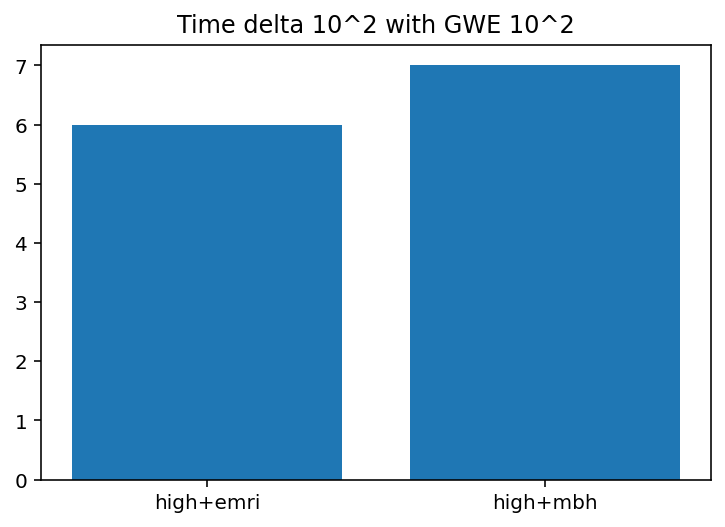

In [565]:
# Plot number of overlap events
plt.bar(["high+emri", "high+mbh"], np.sum(m, axis=0));
plt.title("Time delta 10^%i with GWE 10^%i" % (timelog, gwe));

Playground for plotting

In [383]:
if np.sum(m) > 0:
    flatenergy = np.concatenate([np.concatenate(i) for i in energys])
    flatthets = np.concatenate([np.concatenate(j) for j in costhets])

In [597]:
dset = total_background_nonmuon

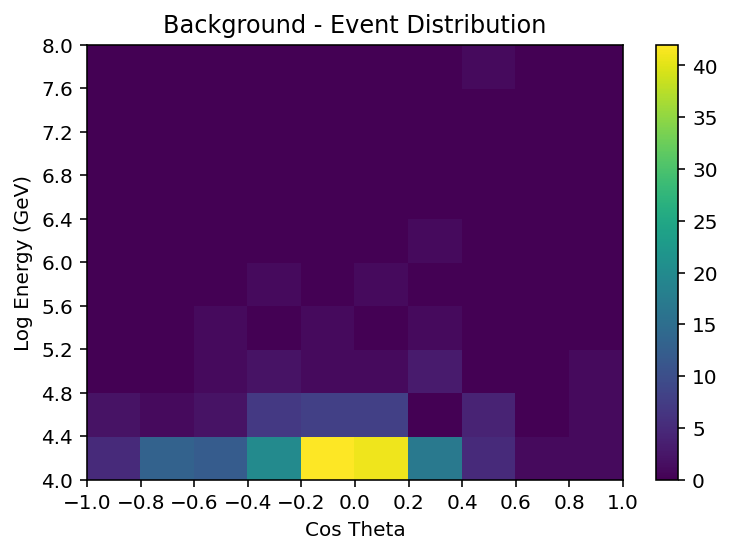

In [602]:
_, xbins, ybins, _ = plt.hist2d(np.cos(dset[0][:,0]), np.log10(dset[3]), range=[[-1,1],[4,8]])
plt.xticks(xbins)
plt.yticks(ybins)
plt.xlabel("Cos Theta")
plt.ylabel(r"Log Energy (GeV)")
plt.title(r"Background - Event Distribution")
plt.colorbar();

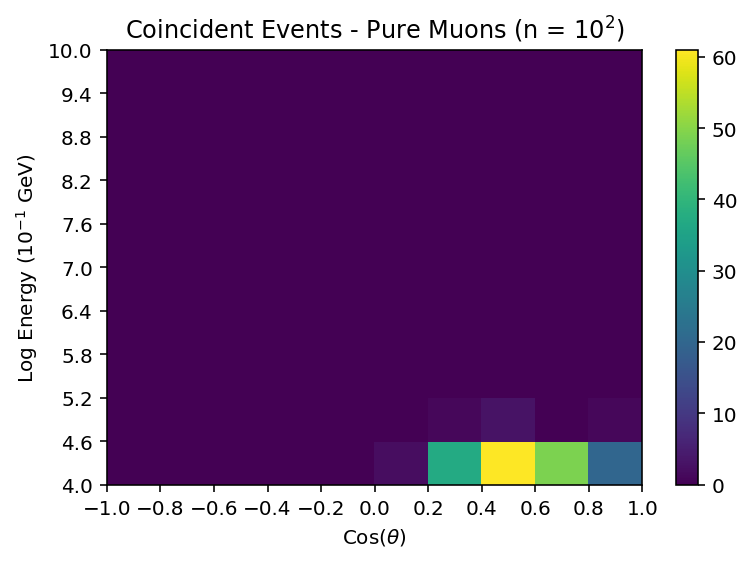

In [413]:
_, xbins, ybins, _ = plt.hist2d(flatthets, np.log10(flatenergy), range=[[-1,1],[4,10]]);
plt.xticks(xbins)
plt.yticks(ybins)
plt.xlabel(r"Cos($\theta$)")
plt.ylabel(r"Log Energy ($10^{-1}$ GeV)")
plt.title(r"Coincident Events - Pure Muons (n = $10^%i$)" % int(np.log10(n)))
plt.colorbar();

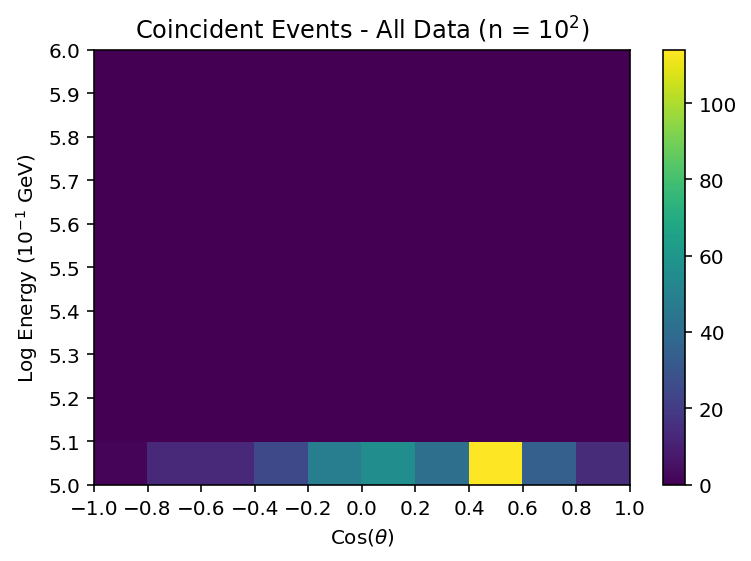

In [182]:
_, xbins, ybins, _ = plt.hist2d(flatthets, np.log10(flatenergy), range=[[-1,1],[5,6]]);
plt.xticks(xbins)
plt.yticks(ybins)
plt.xlabel(r"Cos($\theta$)")
plt.ylabel(r"Log Energy ($10^{-1}$ GeV)")
plt.title(r"Coincident Events - All Data (n = $10^%i$)" % int(np.log10(n)))
plt.colorbar();